# Imports, spark init, dataset read

In [30]:
from pyspark.sql import SparkSession

import numpy as np
from pyspark.sql.functions import col
import pyspark.sql.functions as sql_func
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, FloatType, BooleanType
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

In [31]:
def init_spark():
    spark = SparkSession \
        .builder \
        .master('local[*]')\
        .appName("Python Spark SQL basic example") \
        .config("spark.driver.memory", "15g")\
        .getOrCreate()
    return spark

We do not need 'Country' column, since it only has one value, it is clear we work in the scope of USA, 
'id' provides no relevant information either, so can be dropped

We also add a year column to easily distinguish on when the specific accdent occured

In [32]:
def read_dataset(filename):
    spark = init_spark()
    total_accidents_data = spark.read.csv(filename, header=True, mode="DROPMALFORMED", encoding="ISO-8859-1", inferSchema=True)
    # dropped meaningless and 1 class only columns
    final_result = total_accidents_data.drop('Country').drop('id')\
        .withColumn('start_year', sql_func.date_format(total_accidents_data.Start_Time, 'y'))
      
    return final_result

In [33]:
root_accidents_data = read_dataset('data/US_Accidents_Dec20.csv')
root_accidents_data.printSchema()

root
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doub

To reflect on the above output:
TMC - is the accident code assigned by the authorities full list can be found here:
https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List

In [34]:
# Total dataset count is:
root_accidents_data.count()

4232541

# Data analysis

### Data source and meta

In [54]:
# we will use these functions to display a pie chart of a column
def display_piechart_of_column(accidents_dataframe: DataFrame, column_name: str):
    counted_accidents = accidents_dataframe.groupBy(column_name).count().filter(col(column_name) != 'null')\
        .withColumn(column_name, col(column_name).cast('string'))
    counted_accidents.printSchema()
    counted_accidents = counted_accidents.collect()
    labels = [label[column_name] for label in counted_accidents]
    counts = [label['count'] for label in counted_accidents]
    count_sum = reduce(lambda x, y: x + y, counts)
    percentages = [count/count_sum for count in counts]
    piechart(labels, percentages, column_name)


def piechart(labels, percentages, column_name):
    plt.pie(percentages, labels=labels)
    plt.title(f'ratio by {column_name}')
    plt.show()

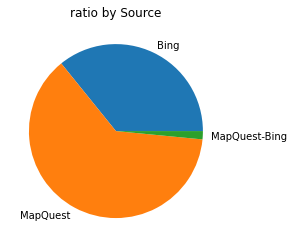

In [47]:
display_piechart_of_column(root_accidents_data, 'Source')

As can be seen above the data comes from 3 sources: MapQuest, Bing, and a mix up of MapQuest-Bing

In [45]:
root_accidents_data.printSchema()

root
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doub

In [55]:
bing = root_accidents_data.filter(col('Source') == 'Bing')
display_piechart_of_column(bing, 'Severity')

root
 |-- Severity: string (nullable = true)
 |-- count: long (nullable = false)



TypeError: reduce() of empty sequence with no initial value

# Data cleanup, processing

# Regression